# HW03 Fine-tuning

Dataset could be found on adress: https://drive.google.com/file/d/1sWyEVb0OVMCUlVIKEe831bCU2QGZJgHM/edit
- Some pictures needed to be deleted, because they could not be loaded with PIL Python library, hence there is unbalanced number of instances in dataset 
- However, it did not have influence on fine-tuning functionality

In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


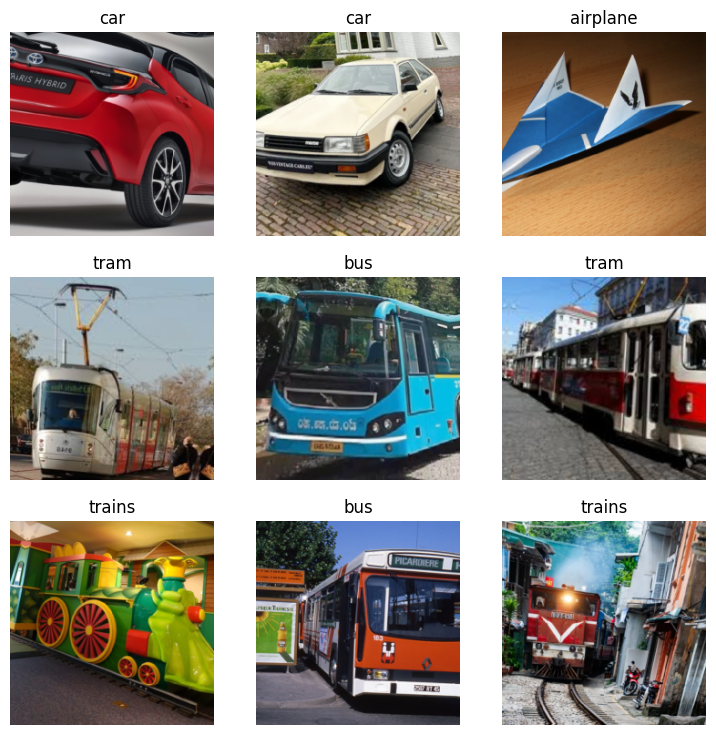

In [16]:
from fastai.vision.all import *
from pathlib import Path

path = Path('data/transport_dataset') / 'train'

dls = ImageDataLoaders.from_folder(
    path,                 # Path to the rain folder
    train='.',            # Use the entire train folder for splitting
    valid_pct=0.2,        # 20% of the data will be used for validation
    seed=42,              # Set a seed for reproducibility
    item_tfms=Resize(460),# Resize the images to 460x460 (or your desired size)
    batch_tfms=aug_transforms(size=224, min_scale=0.75), # Data augmentation 
    bs=64                 # Batch size 64
)

dls.show_batch(max_n=9)

In [17]:
from timm import list_models
list_models(pretrained=True)
learn = vision_learner(dls, resnet34, metrics=error_rate)

In [18]:
lr = 0.001
epochs =  5
learn.fine_tune(epochs, lr)

epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time
0,0.778521,0.404183,0.131579,00:12
1,0.602060,0.260602,0.078947,00:13
2,0.455233,0.184456,0.078947,00:13
3,0.358268,0.168235,0.059211,00:13
4,0.291089,0.166046,0.059211,00:12


Evaluate the model's performance...

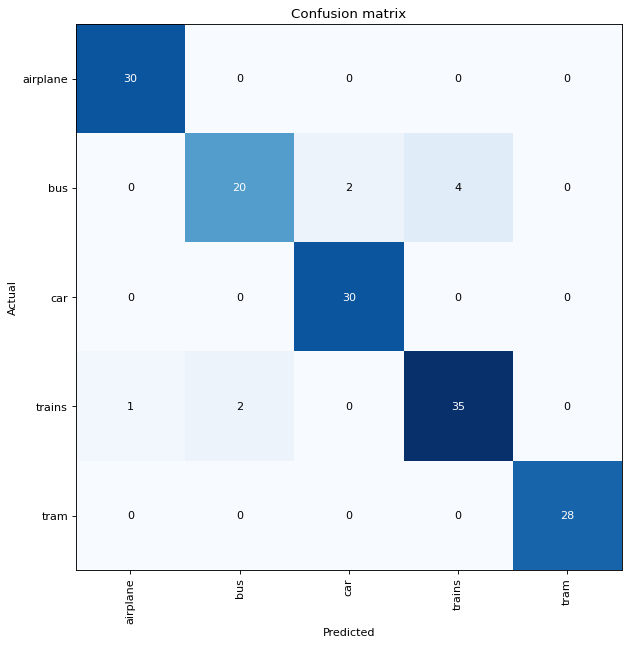

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

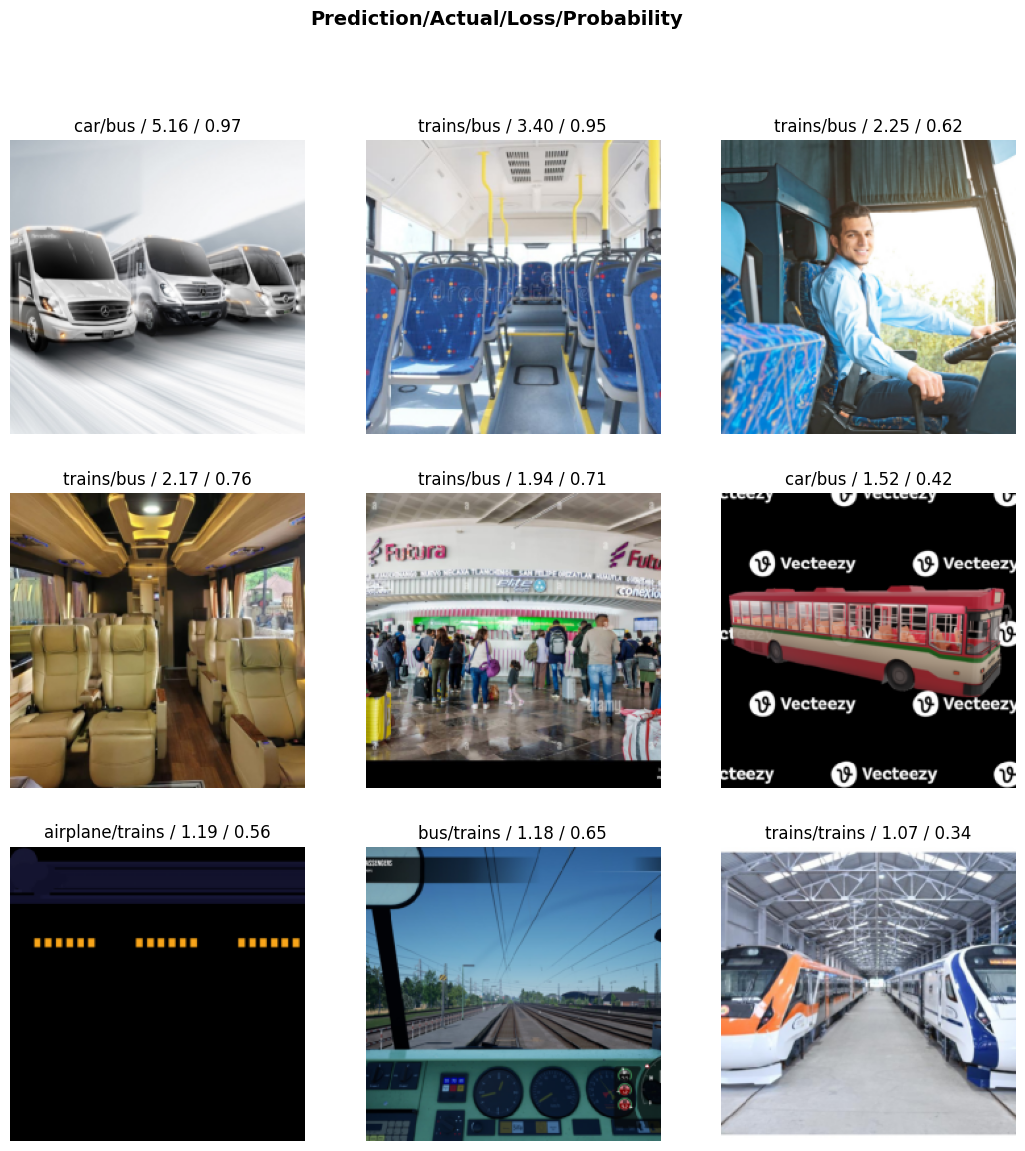

In [20]:
interp.plot_top_losses(9, figsize=(13,13))

In [ ]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

Deleted improper pictures (e.g. shots from movies with names including "plane", "car"...), interior of the vehicles... 

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
print(len(cleaner.delete()))

## Test the model on a test set

In [22]:
# Create a test DataLoader
test_path = Path('data/transport_dataset') / 'test'
test_dl = learn.dls.test_dl(get_image_files(test_path))

In [23]:
# Get predictions
preds, targets = learn.get_preds(dl=test_dl)
pred_labels = torch.argmax(preds, dim=1)

In [24]:
# Get class names
class_names = learn.dls.vocab
# Convert predictions to class names
pred_class_names = [class_names[i] for i in pred_labels]
true_class_names = [Path(t).parent.name for t in test_dl.items]

In [25]:
from statistics import mean

print("Test error rate:")
print(1 - mean([actual == predicted for actual, predicted in zip(true_class_names, pred_class_names)]))

Test error rate:
0.07751937984496127


In [26]:
learn.export('/teamspace/studios/this_studio/model.pkl')